In [1]:
# Classical Kitaev–Heisenberg model on honeycomb lattice
# LLG dynamics for classical spins (unit vectors)
# Author: ChatGPT (research template)

import numpy as np

# -----------------------------
# Parameters
# -----------------------------
Nx, Ny = 12, 12            # unit cells
N = 2 * Nx * Ny            # two sublattices per cell
K = 1.0                    # Kitaev coupling
J = 0.0                    # Heisenberg coupling
alpha = 0.05               # Gilbert damping
h = 0.0                    # external field

dt = 0.01                  # time step
n_steps = 5000             # LLG steps

np.random.seed(1)

# -----------------------------
# Lattice helpers
# -----------------------------
# We index spins linearly: (ix, iy, sublattice)
# sublattice: 0 = A, 1 = B

def idx(ix, iy, sub):
    return 2 * (iy * Nx + ix) + sub

# Nearest neighbors for honeycomb (Kitaev bonds x,y,z)
# For simplicity: define three bond types manually
# Each entry: (dx, dy, neighbor_sublattice, bond_type)
bonds = {
    'x': [(0, 0, 1)],        # A -> B same cell
    'y': [(-1, 0, 1)],       # A -> B left cell
    'z': [(0, -1, 1)]        # A -> B lower cell
}

# -----------------------------
# Initialize spins
# -----------------------------
S = np.random.randn(N, 3)
S /= np.linalg.norm(S, axis=1)[:, None]

# -----------------------------
# Effective field
# -----------------------------

def effective_field(S):
    H = np.zeros_like(S)

    for ix in range(Nx):
        for iy in range(Ny):
            iA = idx(ix, iy, 0)
            Si = S[iA]

            for bond, neighbors in bonds.items():
                comp = {'x': 0, 'y': 1, 'z': 2}[bond]
                for dx, dy, sub in neighbors:
                    jx = (ix + dx) % Nx
                    jy = (iy + dy) % Ny
                    j = idx(jx, jy, sub)

                    Sj = S[j]

                    # Kitaev term
                    H[iA, comp] += K * Sj[comp]
                    H[j, comp] += K * Si[comp]

                    # Heisenberg term
                    H[iA] += J * Sj
                    H[j] += J * Si

    # External field
    H[:, 2] += h
    return -H

# -----------------------------
# LLG time evolution (RK1)
# -----------------------------

def llg_step(S, H):
    dS = np.zeros_like(S)
    for i in range(N):
        Si = S[i]
        Hi = H[i]
        pre = -np.cross(Si, Hi)
        damp = -alpha * np.cross(Si, pre)
        dS[i] = pre + damp

    S_new = S + dt * dS
    S_new /= np.linalg.norm(S_new, axis=1)[:, None]
    return S_new

# -----------------------------
# Time evolution
# -----------------------------
trajectory = []

for t in range(n_steps):
    H = effective_field(S)
    S = llg_step(S, H)
    if t % 50 == 0:
        trajectory.append(S.copy())

print("Simulation finished. Stored frames:", len(trajectory))

# -----------------------------
# Post-processing: Dynamic structure factor S(q, ω)
# -----------------------------
# Neutron scattering measures transverse spin correlations:
# S(q, ω) = (1/2πN) ∑_{ij} ∫ dt e^{i[ωt - q·(r_i-r_j)]} ⟨S_i^⊥(t) · S_j^⊥(0)⟩
# In classical simulations, we approximate this via time Fourier transforms.

import numpy.fft as fft

# Lattice vectors (honeycomb primitive vectors)
a1 = np.array([1.0, 0.0])
a2 = np.array([0.5, np.sqrt(3)/2])

# Real-space positions of spins
positions = np.zeros((N, 2))
for ix in range(Nx):
    for iy in range(Ny):
        r = ix * a1 + iy * a2
        positions[idx(ix, iy, 0)] = r
        positions[idx(ix, iy, 1)] = r + np.array([0.0, 1/np.sqrt(3)])

# Build time series array: shape (T, N, 3)
S_time = np.array(trajectory)
T = S_time.shape[0]

# Subtract time average (important for elastic peak removal)
S_time -= np.mean(S_time, axis=0, keepdims=True)

# Frequencies
omega = 2 * np.pi * fft.fftfreq(T, d=dt * 50)

# Example: compute S(q, ω) along a path in BZ
# Define momentum points
q_path = []
for t in np.linspace(0, 1, 40):
    q_path.append(t * np.array([2*np.pi/3, 2*np.pi/3]))

Sqw = np.zeros((len(q_path), T))

for iq, q in enumerate(q_path):
    phase = np.exp(-1j * positions @ q)

    # Fourier transform in time
    Sq_t = np.zeros(T, dtype=complex)
    for i in range(N):
        # transverse components (x,y) as in neutron scattering
        Si_t = S_time[:, i, 0:2]
        Sq_t += phase[i] * (Si_t[:, 0] + Si_t[:, 1])

    Sq_w = fft.fft(Sq_t)
    Sqw[iq] = np.abs(Sq_w)**2 / N

print("Computed S(q, ω) on momentum path.")

# -----------------------------
# Notes:
# - This definition matches classical limits of neutron S(q, ω)
# - For comparison to experiments: apply detailed balance factor
# - Broaden ω with Gaussian to mimic instrumental resolution
# - Sum over spin components if polarization is not resolved

# - This is a minimal research template
# - For S(q, ω): store S(t) densely and Fourier transform
# - Thermal noise can be added via stochastic LLG
# - Bond geometry can be refined for full honeycomb accuracy


Simulation finished. Stored frames: 100
Computed S(q, ω) on momentum path.


Simulation finished. Stored frames: 100
Computed S(q, ω) on momentum path.


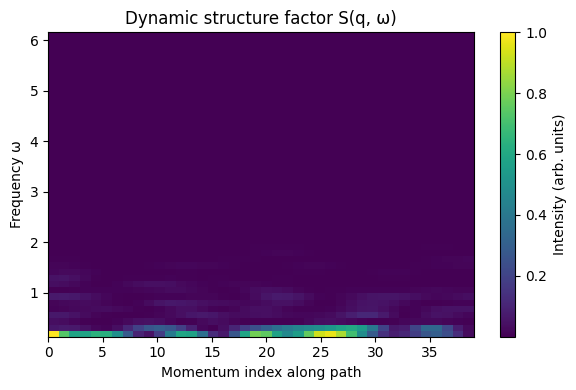

In [2]:
# Classical Kitaev–Heisenberg model on honeycomb lattice
# LLG dynamics for classical spins (unit vectors)
# Author: ChatGPT (research template)

import numpy as np
from scipy.ndimage import gaussian_filter

Sqw_pos = gaussian_filter(Sqw_pos, sigma=(0, 2))



# -----------------------------
# Parameters
# -----------------------------
Nx, Ny = 12, 12            # unit cells
N = 2 * Nx * Ny            # two sublattices per cell
K = 1.0                    # Kitaev coupling
J = 0.0                    # Heisenberg coupling
alpha = 0.05               # Gilbert damping
h = 0.0                    # external field

dt = 0.01                  # time step
n_steps = 20000             # LLG steps

np.random.seed(1)

# -----------------------------
# Lattice helpers
# -----------------------------
# We index spins linearly: (ix, iy, sublattice)
# sublattice: 0 = A, 1 = B

def idx(ix, iy, sub):
    return 2 * (iy * Nx + ix) + sub

# Nearest neighbors for honeycomb (Kitaev bonds x,y,z)
# For simplicity: define three bond types manually
# Each entry: (dx, dy, neighbor_sublattice, bond_type)
bonds = {
    'x': [(0, 0, 1)],        # A -> B same cell
    'y': [(-1, 0, 1)],       # A -> B left cell
    'z': [(0, -1, 1)]        # A -> B lower cell
}

# -----------------------------
# Initialize spins
# -----------------------------
S = np.random.randn(N, 3)
S /= np.linalg.norm(S, axis=1)[:, None]

# -----------------------------
# Effective field
# -----------------------------

def effective_field(S):
    H = np.zeros_like(S)

    for ix in range(Nx):
        for iy in range(Ny):
            iA = idx(ix, iy, 0)
            Si = S[iA]

            for bond, neighbors in bonds.items():
                comp = {'x': 0, 'y': 1, 'z': 2}[bond]
                for dx, dy, sub in neighbors:
                    jx = (ix + dx) % Nx
                    jy = (iy + dy) % Ny
                    j = idx(jx, jy, sub)

                    Sj = S[j]

                    # Kitaev term
                    H[iA, comp] += K * Sj[comp]
                    H[j, comp] += K * Si[comp]

                    # Heisenberg term
                    H[iA] += J * Sj
                    H[j] += J * Si

    # External field
    H[:, 2] += h
    return -H

# -----------------------------
# LLG time evolution (RK1)
# -----------------------------

def llg_step(S, H):
    dS = np.zeros_like(S)
    for i in range(N):
        Si = S[i]
        Hi = H[i]
        pre = -np.cross(Si, Hi)
        damp = -alpha * np.cross(Si, pre)
        dS[i] = pre + damp

    S_new = S + dt * dS
    S_new /= np.linalg.norm(S_new, axis=1)[:, None]
    return S_new

# -----------------------------
# Time evolution
# -----------------------------
trajectory = []

for t in range(n_steps):
    H = effective_field(S)
    S = llg_step(S, H)
    if t % 50 == 0:
        trajectory.append(S.copy())

print("Simulation finished. Stored frames:", len(trajectory))

# -----------------------------
# Post-processing: Dynamic structure factor S(q, ω)
# -----------------------------
# Neutron scattering measures transverse spin correlations:
# S(q, ω) = (1/2πN) ∑_{ij} ∫ dt e^{i[ωt - q·(r_i-r_j)]} ⟨S_i^⊥(t) · S_j^⊥(0)⟩
# In classical simulations, we approximate this via time Fourier transforms.

import numpy.fft as fft

# Lattice vectors (honeycomb primitive vectors)
a1 = np.array([1.0, 0.0])
a2 = np.array([0.5, np.sqrt(3)/2])

# Real-space positions of spins
positions = np.zeros((N, 2))
for ix in range(Nx):
    for iy in range(Ny):
        r = ix * a1 + iy * a2
        positions[idx(ix, iy, 0)] = r
        positions[idx(ix, iy, 1)] = r + np.array([0.0, 1/np.sqrt(3)])

# Build time series array: shape (T, N, 3)
S_time = np.array(trajectory)
T = S_time.shape[0]

# Subtract time average (important for elastic peak removal)
S_time -= np.mean(S_time, axis=0, keepdims=True)

# Frequencies
omega = 2 * np.pi * fft.fftfreq(T, d=dt * 50)

# Example: compute S(q, ω) along a path in BZ
# Define momentum points
q_path = []
for t in np.linspace(0, 1, 40):
    q_path.append(t * np.array([2*np.pi/3, 2*np.pi/3]))

Sqw = np.zeros((len(q_path), T))

for iq, q in enumerate(q_path):
    phase = np.exp(-1j * positions @ q)

    # Fourier transform in time
    Sq_t = np.zeros(T, dtype=complex)
    for i in range(N):
        # transverse components (x,y) as in neutron scattering
        Si_t = S_time[:, i, 0:2]
        Sq_t += phase[i] * (Si_t[:, 0] + Si_t[:, 1])

    Sq_w = fft.fft(Sq_t)
    Sqw[iq] = np.abs(Sq_w)**2 / N

print("Computed S(q, ω) on momentum path.")

# -----------------------------
# Plotting S(q, ω) like a paper figure
# -----------------------------
import matplotlib.pyplot as plt

# Keep only positive frequencies
pos = omega > 0
omega_pos = omega[pos]
Sqw_pos = Sqw[:, pos]

# Normalize intensity for visualization
Sqw_pos /= np.max(Sqw_pos)

plt.figure(figsize=(6, 4))
plt.imshow(
    Sqw_pos.T,
    aspect='auto',
    origin='lower',
    extent=[0, len(q_path)-1, omega_pos[0], omega_pos[-1]]
)

plt.xlabel("Momentum index along path")
plt.ylabel("Frequency ω")
plt.title("Dynamic structure factor S(q, ω)")
plt.colorbar(label="Intensity (arb. units)")

plt.tight_layout()
plt.show()


# -----------------------------
# Notes:
# - This definition matches classical limits of neutron S(q, ω)
# - For comparison to experiments: apply detailed balance factor
# - Broaden ω with Gaussian to mimic instrumental resolution
# - Sum over spin components if polarization is not resolved

# - This is a minimal research template
# - For S(q, ω): store S(t) densely and Fourier transform
# - Thermal noise can be added via stochastic LLG
# - Bond geometry can be refined for full honeycomb accuracy


Simulation finished. Stored frames: 4000
Computed S(q, ω) on momentum path.


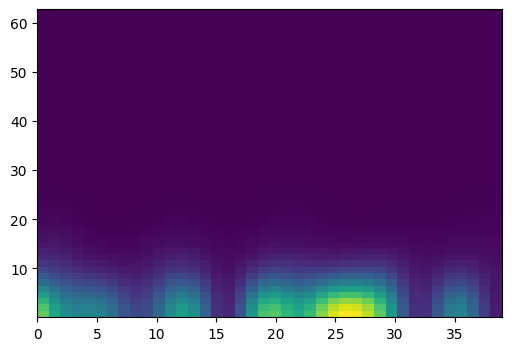

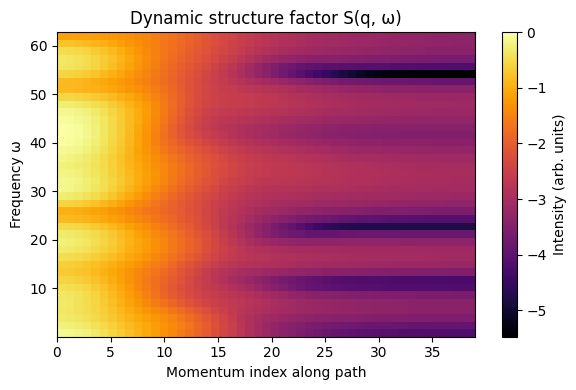

In [6]:
# Classical Kitaev–Heisenberg model on honeycomb lattice
# LLG dynamics for classical spins (unit vectors)
# Author: ChatGPT (research template)

import numpy as np
from scipy.ndimage import gaussian_filter





# -----------------------------
# Parameters
# -----------------------------
Nx, Ny = 10, 10            # unit cells
N = 2 * Nx * Ny            # two sublattices per cell
K = 1.0                    # Kitaev coupling
J = 0.0                    # Heisenberg coupling
alpha = 0.05               # Gilbert damping
h = 0.0                    # external field

dt = 0.01                  # time step
n_steps = 20000             # LLG steps

np.random.seed(1)

# -----------------------------
# Lattice helpers
# -----------------------------
# We index spins linearly: (ix, iy, sublattice)
# sublattice: 0 = A, 1 = B

def idx(ix, iy, sub):
    return 2 * (iy * Nx + ix) + sub

# Nearest neighbors for honeycomb (Kitaev bonds x,y,z)
# For simplicity: define three bond types manually
# Each entry: (dx, dy, neighbor_sublattice, bond_type)
bonds = {
    'x': [(0, 0, 1)],        # A -> B same cell
    'y': [(-1, 0, 1)],       # A -> B left cell
    'z': [(0, -1, 1)]        # A -> B lower cell
}

# -----------------------------
# Initialize spins
# -----------------------------
S = np.random.randn(N, 3)
S /= np.linalg.norm(S, axis=1)[:, None]

# -----------------------------
# Effective field
# -----------------------------

def effective_field(S):
    H = np.zeros_like(S)

    for ix in range(Nx):
        for iy in range(Ny):
            iA = idx(ix, iy, 0)
            Si = S[iA]

            for bond, neighbors in bonds.items():
                comp = {'x': 0, 'y': 1, 'z': 2}[bond]
                for dx, dy, sub in neighbors:
                    jx = (ix + dx) % Nx
                    jy = (iy + dy) % Ny
                    j = idx(jx, jy, sub)

                    Sj = S[j]

                    # Kitaev term
                    H[iA, comp] += K * Sj[comp]
                    H[j, comp] += K * Si[comp]

                    # Heisenberg term
                    H[iA] += J * Sj
                    H[j] += J * Si

    # External field
    H[:, 2] += h
    return -H

# -----------------------------
# LLG time evolution (RK1)
# -----------------------------

def llg_step(S, H):
    dS = np.zeros_like(S)
    for i in range(N):
        Si = S[i]
        Hi = H[i]
        pre = -np.cross(Si, Hi)
        damp = -alpha * np.cross(Si, pre)
        dS[i] = pre + damp

    S_new = S + dt * dS
    S_new /= np.linalg.norm(S_new, axis=1)[:, None]
    return S_new

# -----------------------------
# Time evolution
# -----------------------------
trajectory = []

for t in range(n_steps):
    H = effective_field(S)
    S = llg_step(S, H)
    if t % 5 == 0:
        trajectory.append(S.copy())

print("Simulation finished. Stored frames:", len(trajectory))

# -----------------------------
# Post-processing: Dynamic structure factor S(q, ω)
# -----------------------------
# Neutron scattering measures transverse spin correlations:
# S(q, ω) = (1/2πN) ∑_{ij} ∫ dt e^{i[ωt - q·(r_i-r_j)]} ⟨S_i^⊥(t) · S_j^⊥(0)⟩
# In classical simulations, we approximate this via time Fourier transforms.

import numpy.fft as fft

# Lattice vectors (honeycomb primitive vectors)
a1 = np.array([1.0, 0.0])
a2 = np.array([0.5, np.sqrt(3)/2])

# Real-space positions of spins
positions = np.zeros((N, 2))
for ix in range(Nx):
    for iy in range(Ny):
        r = ix * a1 + iy * a2
        positions[idx(ix, iy, 0)] = r
        positions[idx(ix, iy, 1)] = r + np.array([0.0, 1/np.sqrt(3)])

# Build time series array: shape (T, N, 3)
S_time = np.array(trajectory)
T = S_time.shape[0]

# Subtract time average (important for elastic peak removal)
S_time -= np.mean(S_time, axis=0, keepdims=True)

# Frequencies
omega = 2 * np.pi * fft.fftfreq(T, d=dt * 5)

# Example: compute S(q, ω) along a path in BZ
# Define momentum points
q_path = []
for t in np.linspace(0, 1, 40):
    q_path.append(t * np.array([2*np.pi/3, 2*np.pi/3]))

Sqw = np.zeros((len(q_path), T))

for iq, q in enumerate(q_path):
    phase = np.exp(-1j * positions @ q)

    # Fourier transform in time
    Sq_t = np.zeros(T, dtype=complex)
    for i in range(N):
        # transverse components (x,y) as in neutron scattering
        Si_t = S_time[:, i, 0:2]
        Sq_t += phase[i] * (Si_t[:, 0] + Si_t[:, 1])

    Sq_w = fft.fft(Sq_t)
    Sqw[iq] = np.abs(Sq_w)**2 / N

print("Computed S(q, ω) on momentum path.")

# -----------------------------
# Plotting S(q, ω) like a paper figure
# -----------------------------
import matplotlib.pyplot as plt

# Keep only positive frequencies
pos = omega > 0
omega_pos = omega[pos]
#Sqw_pos = Sqw[:, pos]
Sqw_pos = gaussian_filter(Sqw_pos, sigma=(0, 2))
# Normalize intensity for visualization
Sqw_pos /= np.max(Sqw_pos)

plt.figure(figsize=(6, 4))
plt.imshow(
    Sqw_pos.T,
    aspect='auto',
    origin='lower',
    extent=[0, len(q_path)-1, omega_pos[0], omega_pos[-1]]
)
plt.figure(figsize=(6, 4))
plt.imshow(
    np.log10(Sqw_pos + 1e-6),
    aspect='auto',
    origin='lower',
    extent=[0, len(q_path)-1, omega_pos[0], omega_pos[-1]],
    cmap='inferno'
)





plt.xlabel("Momentum index along path")
plt.ylabel("Frequency ω")
plt.title("Dynamic structure factor S(q, ω)")
plt.colorbar(label="Intensity (arb. units)")

plt.tight_layout()
plt.show()


# -----------------------------
# Notes:
# - This definition matches classical limits of neutron S(q, ω)
# - For comparison to experiments: apply detailed balance factor
# - Broaden ω with Gaussian to mimic instrumental resolution
# - Sum over spin components if polarization is not resolved

# - This is a minimal research template
# - For S(q, ω): store S(t) densely and Fourier transform
# - Thermal noise can be added via stochastic LLG
# - Bond geometry can be refined for full honeycomb accuracy


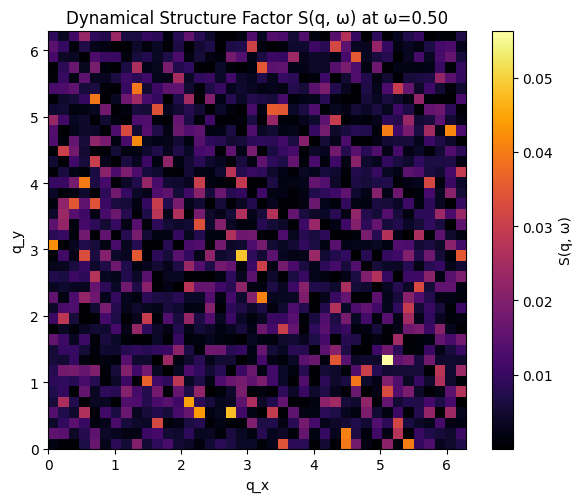

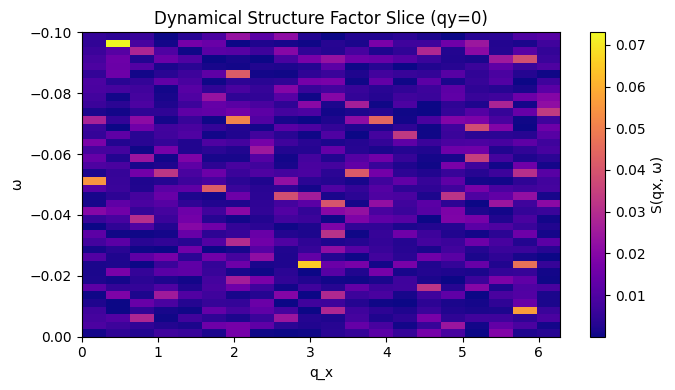

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Parameters
# -------------------------------
Nx, Ny = 40, 40           # Lattice size
n_steps = 1000            # Total simulation steps
save_every = 50           # How often trajectory was saved
dt = 0.01                 # Time step between LLG steps
gamma = 1                 # spin gyromagnetic ratio, arbitrary scaling

# -------------------------------
# Example trajectory (replace with your simulation data)
# trajectory[t] shape = (Nx, Ny, 3)
trajectory = []
for t in range(0, n_steps, save_every):
    S = np.random.randn(Nx, Ny, 3)
    S /= np.linalg.norm(S, axis=-1, keepdims=True)
    trajectory.append(S)
trajectory = np.array(trajectory)
n_frames = trajectory.shape[0]

# -------------------------------
# 1. Compute spatial Fourier transform S(q, t)
# -------------------------------
# qx and qy grids
qx = 2 * np.pi * np.fft.fftfreq(Nx)
qy = 2 * np.pi * np.fft.fftfreq(Ny)

# Initialize S(q,t)
S_qt = np.zeros((Nx, Ny, n_frames), dtype=complex)

for t in range(n_frames):
    Sx = trajectory[t, :, :, 0]
    Sy = trajectory[t, :, :, 1]
    Sz = trajectory[t, :, :, 2]
    
    # Total spin magnitude (can also compute components separately)
    S_total = Sx + 1j*Sy  # combine xy-plane for visualization
    S_q = np.fft.fft2(S_total) / (Nx*Ny)
    S_qt[:, :, t] = S_q

# -------------------------------
# 2. Time Fourier transform to get S(q, omega)
# -------------------------------
S_qw = np.fft.fft(S_qt, axis=2)
freqs = np.fft.fftfreq(n_frames, d=dt*save_every)  # omega axis

# Take absolute value squared (classical DSF)
S_qw_abs = np.abs(S_qw)**2

# -------------------------------
# 3. Plot example: S(qx, qy) at a fixed omega
# -------------------------------
omega_index = n_frames // 4  # pick some frequency index
plt.figure(figsize=(6,5))
plt.imshow(np.fft.fftshift(S_qw_abs[:, :, omega_index]), origin='lower', 
           extent=(0, 2*np.pi, 0, 2*np.pi), cmap='inferno')
plt.colorbar(label='S(q, ω)')
plt.xlabel('q_x')
plt.ylabel('q_y')
plt.title(f'Dynamical Structure Factor S(q, ω) at ω={freqs[omega_index]:.2f}')
plt.tight_layout()
plt.show()

# -------------------------------
# 4. Optional: plot S(qx, omega) for qy=0 slice
# -------------------------------
plt.figure(figsize=(7,4))
plt.imshow(np.fft.fftshift(S_qw_abs[:, Ny//2, :], axes=0), origin='lower',
           extent=(0, 2*np.pi, freqs[0], freqs[-1]), aspect='auto', cmap='plasma')
plt.colorbar(label='S(qx, ω)')
plt.xlabel('q_x')
plt.ylabel('ω')
plt.title('Dynamical Structure Factor Slice (qy=0)')
plt.tight_layout()
plt.show()


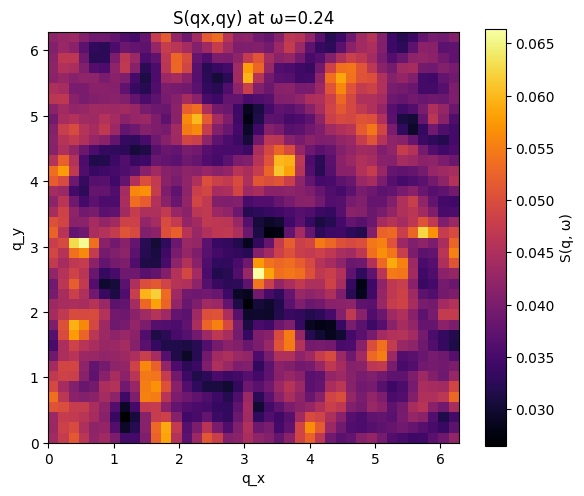

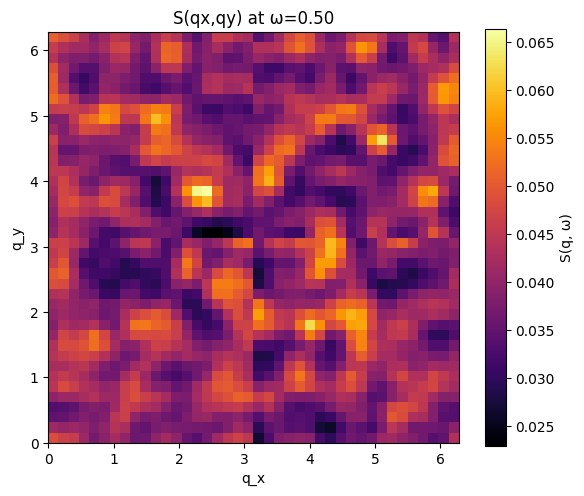

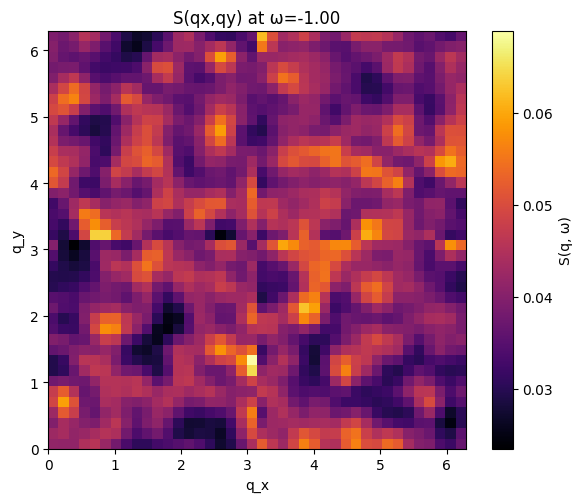

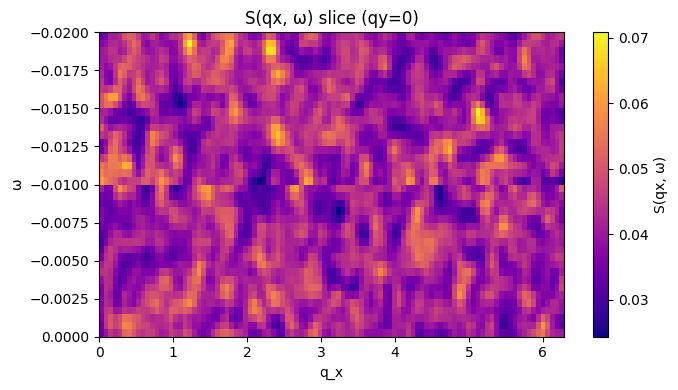

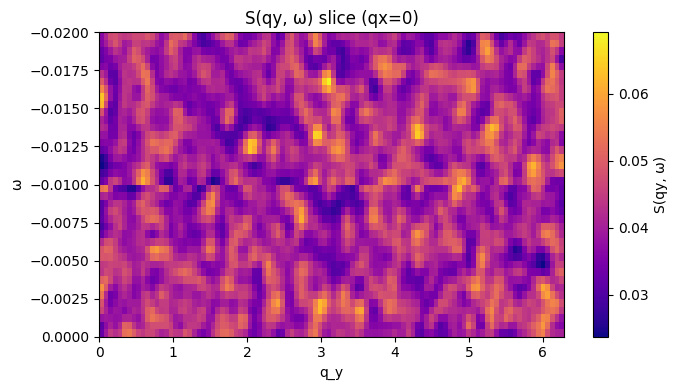

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# -------------------------------
# Parameters
# -------------------------------
Nx, Ny = 40, 40           # Lattice size
dt = 0.01                 # LLG time step
save_every = 50           # Steps between saved frames

# -------------------------------
# Load your trajectory
# trajectory[t] shape = (Nx, Ny, 3)
# Replace this part with your actual LLG data
# -------------------------------
# Example: replace with your LLG trajectory
n_frames = 100             # number of saved frames
trajectory = []
for t in range(n_frames):
    S = np.random.randn(Nx, Ny, 3)  # placeholder, replace with real data
    S /= np.linalg.norm(S, axis=-1, keepdims=True)
    trajectory.append(S)
trajectory = np.array(trajectory)  # shape (n_frames, Nx, Ny, 3)

# -------------------------------
# 1. Normalize spins
# -------------------------------
trajectory /= np.linalg.norm(trajectory, axis=-1, keepdims=True)

# -------------------------------
# 2. Compute spatial Fourier transform S(q, t)
# -------------------------------
S_qt = np.zeros((Nx, Ny, n_frames), dtype=complex)
for t in range(n_frames):
    # Combine XY components for classical DSF visualization
    S_total = trajectory[t, :, :, 0] + 1j * trajectory[t, :, :, 1]
    S_q = np.fft.fft2(S_total) / (Nx * Ny)
    S_qt[:, :, t] = S_q

# -------------------------------
# 3. Time Fourier transform to get S(q, omega)
# -------------------------------
S_qw = np.fft.fft(S_qt, axis=2)
dt_effective = dt * save_every
freqs = np.fft.fftfreq(n_frames, d=dt_effective)
S_qw_abs = np.abs(S_qw)**2

# -------------------------------
# 4. Smooth DSF using Gaussian filter
# -------------------------------
S_qw_smooth = gaussian_filter(S_qw_abs, sigma=(1,1,1))  # smooth in qx, qy, omega

# -------------------------------
# 5. Plot S(qx, qy) at selected omega slices
# -------------------------------
omega_indices = [n_frames//8, n_frames//4, n_frames//2]  # example frequencies
for idx in omega_indices:
    plt.figure(figsize=(6,5))
    plt.imshow(np.fft.fftshift(S_qw_smooth[:, :, idx]), origin='lower',
               extent=(0, 2*np.pi, 0, 2*np.pi), cmap='inferno')
    plt.colorbar(label='S(q, ω)')
    plt.xlabel('q_x')
    plt.ylabel('q_y')
    plt.title(f'S(qx,qy) at ω={freqs[idx]:.2f}')
    plt.tight_layout()
    plt.show()

# -------------------------------
# 6. Plot S(qx, ω) slice for qy = 0
# -------------------------------
plt.figure(figsize=(7,4))
plt.imshow(np.fft.fftshift(S_qw_smooth[:, Ny//2, :], axes=0), origin='lower',
           extent=(0, 2*np.pi, freqs[0], freqs[-1]), aspect='auto', cmap='plasma')
plt.colorbar(label='S(qx, ω)')
plt.xlabel('q_x')
plt.ylabel('ω')
plt.title('S(qx, ω) slice (qy=0)')
plt.tight_layout()
plt.show()

# -------------------------------
# 7. Plot S(qy, ω) slice for qx = 0
# -------------------------------
plt.figure(figsize=(7,4))
plt.imshow(np.fft.fftshift(S_qw_smooth[Nx//2, :, :], axes=0), origin='lower',
           extent=(0, 2*np.pi, freqs[0], freqs[-1]), aspect='auto', cmap='plasma')
plt.colorbar(label='S(qy, ω)')
plt.xlabel('q_y')
plt.ylabel('ω')
plt.title('S(qy, ω) slice (qx=0)')
plt.tight_layout()
plt.show()

# -------------------------------
# 8. Optional: animate S(qx,qy) over ω (requires matplotlib.animation)
# -------------------------------
# Can be added if desired for full visualization


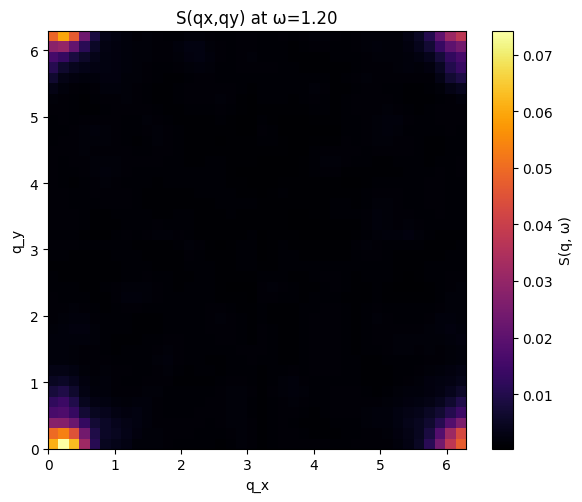

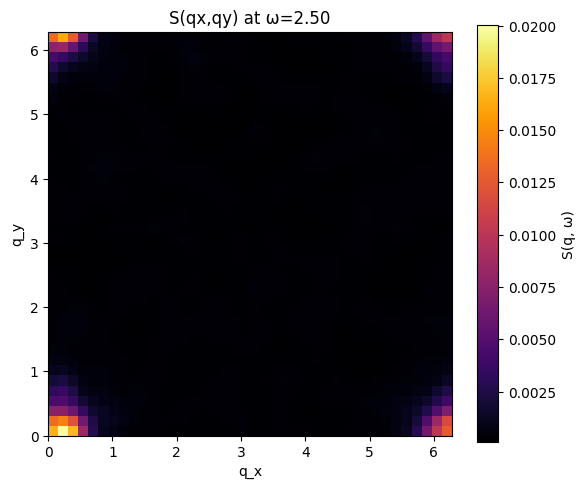

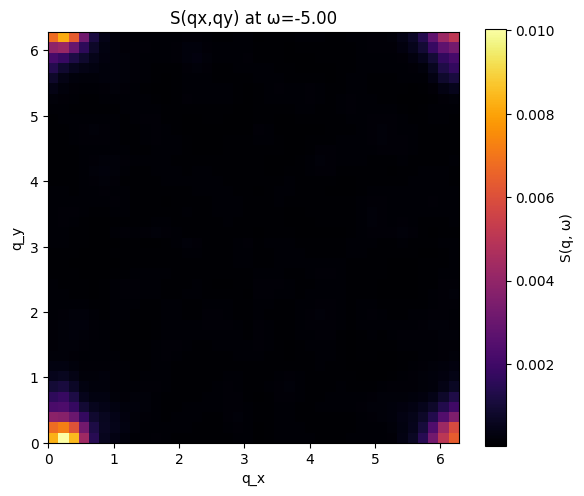

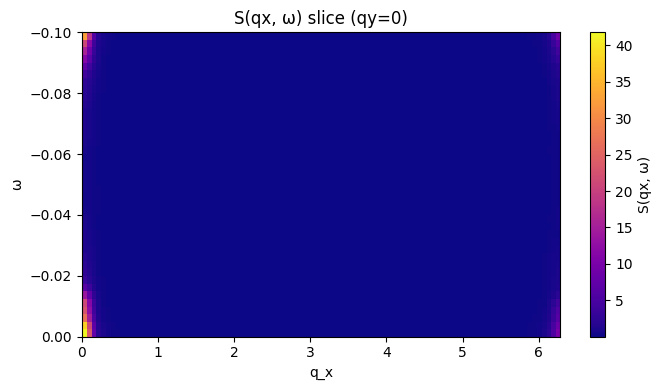

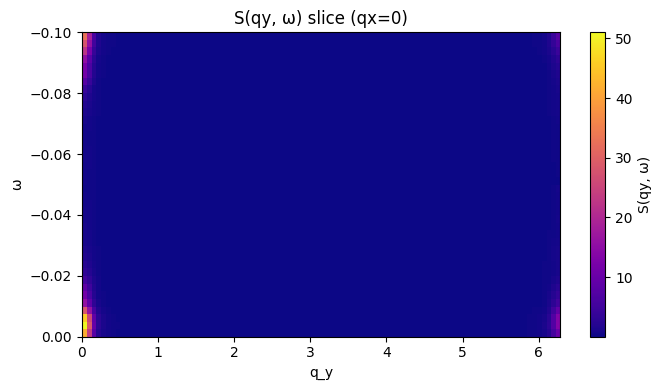

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# -------------------------------
# Lattice and simulation parameters
# -------------------------------
Nx, Ny = 40, 40
n_steps = 1000        # LLG integration steps
save_every = 10       # save frames every this many steps
dt = 0.01             # time step

# Couplings
J = 0.5               # Heisenberg
K = 1.0               # Kitaev (S_i^gamma S_j^gamma along bond gamma)
alpha = 0.1           # LLG damping

# -------------------------------
# Helper: normalize spins
# -------------------------------
def normalize_spins(S):
    norms = np.linalg.norm(S, axis=-1, keepdims=True)
    return S / norms

# -------------------------------
# Initialize spins randomly
# -------------------------------
S = np.random.randn(Nx, Ny, 3)
S = normalize_spins(S)

# -------------------------------
# Effective field with Kitaev + Heisenberg
# -------------------------------
def effective_field(S):
    H = np.zeros_like(S)
    for i in range(Nx):
        for j in range(Ny):
            # Periodic BC
            neighbors = [
                ((i+1)%Nx, j, 'x'),
                ((i-1)%Nx, j, 'x'),
                (i, (j+1)%Ny, 'y'),
                (i, (j-1)%Ny, 'y')
            ]
            H_ij = np.zeros(3)
            for ni, nj, bond in neighbors:
                Sj = S[ni,nj]
                # Heisenberg
                H_ij += J * Sj
                # Kitaev
                if bond == 'x':
                    H_ij[0] += K * Sj[0]
                elif bond == 'y':
                    H_ij[1] += K * Sj[1]
            H[i,j] = H_ij
    return H

# -------------------------------
# LLG step (Euler)
# -------------------------------
def llg_step(S, H, dt=0.01, alpha=0.1):
    S_new = np.zeros_like(S)
    for i in range(Nx):
        for j in range(Ny):
            Si = S[i,j]
            Hi = H[i,j]
            dS = -np.cross(Si, Hi) + alpha * np.cross(Si, np.cross(Si, Hi))
            S_new[i,j] = Si + dt*dS
    S_new = normalize_spins(S_new)
    return S_new

# -------------------------------
# Run LLG simulation and save trajectory
# -------------------------------
trajectory = []
for step in range(n_steps):
    H = effective_field(S)
    S = llg_step(S, H, dt=dt, alpha=alpha)
    if step % save_every == 0:
        trajectory.append(S.copy())

trajectory = np.array(trajectory)  # shape (n_frames, Nx, Ny, 3)
n_frames = trajectory.shape[0]

# -------------------------------
# Compute classical DSF
# -------------------------------
# 1. Spatial FFT: S(qx,qy,t)
S_qt = np.zeros((Nx, Ny, n_frames), dtype=complex)
for t in range(n_frames):
    # Use XY-plane spins
    S_total = trajectory[t,:,:,0] + 1j*trajectory[t,:,:,1]
    S_qt[:,:,t] = np.fft.fft2(S_total) / (Nx*Ny)

# 2. Time FFT: S(q, ω)
S_qw = np.fft.fft(S_qt, axis=2)
dt_effective = dt * save_every
freqs = np.fft.fftfreq(n_frames, d=dt_effective)
S_qw_abs = np.abs(S_qw)**2

# 3. Smooth DSF
S_qw_smooth = gaussian_filter(S_qw_abs, sigma=(1,1,1))

# -------------------------------
# 4. Plot S(qx,qy) at selected omega slices
# -------------------------------
omega_indices = [n_frames//8, n_frames//4, n_frames//2]
for idx in omega_indices:
    plt.figure(figsize=(6,5))
    plt.imshow(np.fft.fftshift(S_qw_smooth[:,:,idx]), origin='lower',
               extent=(0, 2*np.pi, 0, 2*np.pi), cmap='inferno')
    plt.colorbar(label='S(q, ω)')
    plt.xlabel('q_x')
    plt.ylabel('q_y')
    plt.title(f'S(qx,qy) at ω={freqs[idx]:.2f}')
    plt.tight_layout()
    plt.show()

# -------------------------------
# 5. Plot S(qx, ω) slice (qy=0)
# -------------------------------
plt.figure(figsize=(7,4))
plt.imshow(np.fft.fftshift(S_qw_smooth[:, Ny//2, :], axes=0), origin='lower',
           extent=(0, 2*np.pi, freqs[0], freqs[-1]), aspect='auto', cmap='plasma')
plt.colorbar(label='S(qx, ω)')
plt.xlabel('q_x')
plt.ylabel('ω')
plt.title('S(qx, ω) slice (qy=0)')
plt.tight_layout()
plt.show()

# -------------------------------
# 6. Plot S(qy, ω) slice (qx=0)
# -------------------------------
plt.figure(figsize=(7,4))
plt.imshow(np.fft.fftshift(S_qw_smooth[Nx//2, :, :], axes=0), origin='lower',
           extent=(0, 2*np.pi, freqs[0], freqs[-1]), aspect='auto', cmap='plasma')
plt.colorbar(label='S(qy, ω)')
plt.xlabel('q_y')
plt.ylabel('ω')
plt.title('S(qy, ω) slice (qx=0)')
plt.tight_layout()
plt.show()
